In [1]:
#Install required packages
!pip install numpy scikit-learn matplotlib pandas --quiet

In [2]:
#Import required libraries
import os
import time
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype

In [3]:
#Load dataset
cov = fetch_covtype()  
X = cov.data.astype(np.float32)  
y = cov.target.astype(np.int64) 
# Optional: to make labels 0..6
y = y - 1

# Stratify helps keep class balance, but may be a bit slower on large sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# print the shape
X_train.shape, X_test.shape

((435759, 54), (145253, 54))

In [4]:
#Utility functions required for KNN Implemetations
def pairwise_sqeuclidean(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Compute squared Euclidean distances between each row in A (N,D) and vector b (D,).
    Returns (N,)
    """
    diff = A - b
    return np.einsum('ij,ij->i', diff, diff)  # sum of squares per row


def topk_indices_smallest(dist: np.ndarray, k: int) -> np.ndarray:
    """
    Return indices of k smallest elements in dist.
    Uses argpartition (O(N)) + sort of k (O(k log k)).
    """
    if k >= dist.shape[0]:
        return np.argsort(dist)
    idx = np.argpartition(dist, kth=k-1)[:k]
    return idx[np.argsort(dist[idx])]

In [5]:
#KNN Serial implementation functions
def knn_predict_serial(X_train, y_train, X_query, k: int = 5) -> int:
    dist = pairwise_sqeuclidean(X_train, X_query)
    nn_idx = topk_indices_smallest(dist, k)
    nn_labels = y_train[nn_idx]
    # majority vote; tie-breaker: smallest label
    counts = np.bincount(nn_labels)
    return int(np.argmax(counts))


def knn_predict_batch_serial(X_train, y_train, X_test, k: int = 5) -> np.ndarray:
    preds = np.empty((X_test.shape[0],), dtype=np.int64)
    for i in range(X_test.shape[0]):
        preds[i] = knn_predict_serial(X_train, y_train, X_test[i], k=k)
    return preds

In [6]:
#KNN parallel implementation functions
def _local_topk(X_chunk, y_chunk, X_query, k, offset):
    dist = pairwise_sqeuclidean(X_chunk, X_query)
    idx_local = topk_indices_smallest(dist, min(k, dist.shape[0]))
    return dist[idx_local], (idx_local + offset), y_chunk[idx_local]

def knn_predict_parallel(
    X_train, y_train, X_query, k: int = 5, n_jobs: int = 4, n_chunks: int = None
) -> int:
    """
    Exact kNN via shared-memory parallelism:
    - compute distances in parallel over chunks
    - merge local top-k results
    """
    N = X_train.shape[0]
    if n_chunks is None:
        n_chunks = max(n_jobs, 1)

    # chunk boundaries
    boundaries = np.linspace(0, N, n_chunks + 1, dtype=int)
    tasks = []
    for c in range(n_chunks):
        s, e = boundaries[c], boundaries[c+1]
        if s == e:
            continue
        tasks.append((X_train[s:e], y_train[s:e], s))

    results = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(_local_topk)(Xc, yc, X_query, k, off) for (Xc, yc, off) in tasks
    )

    # merge all candidates (at most k per chunk -> at most k*n_chunks)
    all_dist = np.concatenate([r[0] for r in results])
    all_lab  = np.concatenate([r[2] for r in results])

    # select global top-k among candidates
    idx = topk_indices_smallest(all_dist, min(k, all_dist.shape[0]))
    nn_labels = all_lab[idx]
    counts = np.bincount(nn_labels)
    return int(np.argmax(counts))


def knn_predict_batch_parallel(X_train, y_train, X_test, k=5, n_jobs=4, n_chunks=None):
    preds = np.empty((X_test.shape[0],), dtype=np.int64)
    for i in range(X_test.shape[0]):
        preds[i] = knn_predict_parallel(X_train, y_train, X_test[i], k=k, n_jobs=n_jobs, n_chunks=n_chunks)
    return preds

In [7]:
# use small subset for quick correctness test
k = 5
X_test_small = X_test[:50]
y_test_small = y_test[:50]

pred_serial = knn_predict_batch_serial(X_train, y_train, X_test_small, k=k)
pred_par    = knn_predict_batch_parallel(X_train, y_train, X_test_small, k=k, n_jobs=4, n_chunks=4)

print("Predictions equal:", np.array_equal(pred_serial, pred_par))
print("Serial accuracy (subset):", accuracy_score(y_test_small, pred_serial))
print("Parallel accuracy (subset):", accuracy_score(y_test_small, pred_par))

Predictions equal: True
Serial accuracy (subset): 0.94
Parallel accuracy (subset): 0.94


In [8]:
#KNN parallel implementation
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

def knn_predict_batch_parallel_queries(X_train, y_train, X_test, k=5, n_jobs=4):
    preds = Parallel(n_jobs=n_jobs, prefer="threads", batch_size="auto")(
        delayed(knn_predict_serial)(X_train, y_train, X_test[i], k)
        for i in range(X_test.shape[0])
    )
    return np.array(preds, dtype=np.int64)

Serial time: 6.8883s | acc=0.9450
n_jobs= 1: time=6.8951s speedup=1.00x acc=0.9450
n_jobs= 2: time=3.6997s speedup=1.86x acc=0.9450
n_jobs= 4: time=2.0117s speedup=3.42x acc=0.9450
n_jobs= 8: time=1.1658s speedup=5.91x acc=0.9450
n_jobs=12: time=1.0152s speedup=6.78x acc=0.9450
n_jobs=16: time=0.9653s speedup=7.14x acc=0.9450
n_jobs=20: time=0.9213s speedup=7.48x acc=0.9450
n_jobs=24: time=0.9317s speedup=7.39x acc=0.9450
n_jobs=28: time=0.9265s speedup=7.44x acc=0.9450
n_jobs=32: time=0.8528s speedup=8.08x acc=0.9450


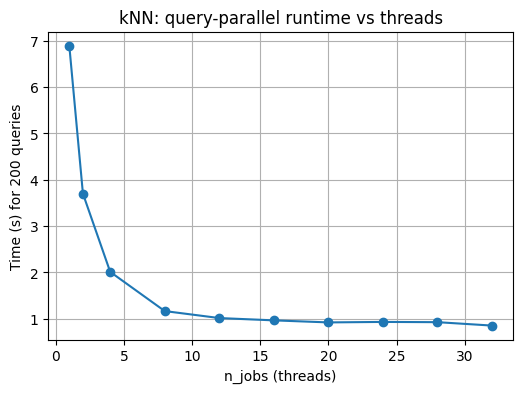

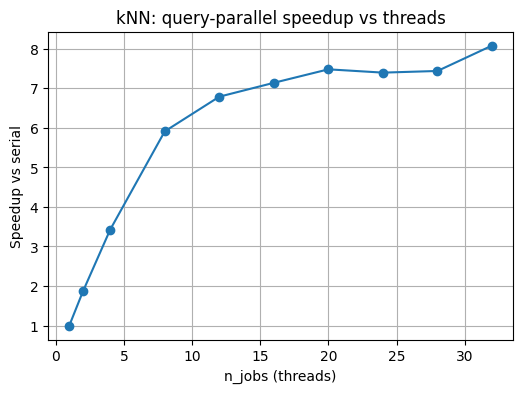

In [9]:
# Code for running running knn with different num of cores
def time_fn(fn, *args, repeats=3, **kwargs):
    best = float("inf")
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = fn(*args, **kwargs)
        best = min(best, time.perf_counter() - t0)
    return best

k = 5
n_train_bench = 400_000
n_test_timing = 200

rng = np.random.default_rng(42)
train_idx = rng.choice(X_train.shape[0], size=min(n_train_bench, X_train.shape[0]), replace=False)
X_train_b = X_train[train_idx]
y_train_b = y_train[train_idx]

X_test_timing = X_test[:n_test_timing]
y_test_timing = y_test[:n_test_timing]

# Serial reference
t_serial = time_fn(knn_predict_batch_serial, X_train_b, y_train_b, X_test_timing, k=k, repeats=3)
ref_preds = knn_predict_batch_serial(X_train_b, y_train_b, X_test_timing, k=k)
ref_acc = accuracy_score(y_test_timing, ref_preds)
print(f"Serial time: {t_serial:.4f}s | acc={ref_acc:.4f}")

threads_list = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
threads_list = [p for p in threads_list if p <= (os.cpu_count() or 1)]

times, speedups, accs = [], [], []
for p in threads_list:
    t = time_fn(knn_predict_batch_parallel_queries, X_train_b, y_train_b, X_test_timing, k=k, n_jobs=p, repeats=3)
    preds = knn_predict_batch_parallel_queries(X_train_b, y_train_b, X_test_timing, k=k, n_jobs=p)
    acc = accuracy_score(y_test_timing, preds)

    times.append(t); speedups.append(t_serial/t); accs.append(acc)
    print(f"n_jobs={p:2d}: time={t:.4f}s speedup={t_serial/t:.2f}x acc={acc:.4f}")

plt.figure(figsize=(6,4))
plt.plot(threads_list, times, marker='o')
plt.xlabel("n_jobs (threads)")
plt.ylabel(f"Time (s) for {n_test_timing} queries")
plt.title("kNN: query-parallel runtime vs threads")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(threads_list, speedups, marker='o')
plt.xlabel("n_jobs (threads)")
plt.ylabel("Speedup vs serial")
plt.title("kNN: query-parallel speedup vs threads")
plt.grid(True)
plt.show()

n_jobs= 1: Q=  25 time=0.8150s  (Q/thread≈25.0)
n_jobs= 2: Q=  50 time=0.9912s  (Q/thread≈25.0)
n_jobs= 4: Q= 100 time=1.0472s  (Q/thread≈25.0)
n_jobs= 8: Q= 200 time=1.2109s  (Q/thread≈25.0)
n_jobs=12: Q= 300 time=1.4816s  (Q/thread≈25.0)
n_jobs=16: Q= 400 time=1.7715s  (Q/thread≈25.0)
n_jobs=20: Q= 500 time=2.0913s  (Q/thread≈25.0)
n_jobs=24: Q= 600 time=2.4158s  (Q/thread≈25.0)
n_jobs=28: Q= 700 time=2.9106s  (Q/thread≈25.0)
n_jobs=32: Q= 800 time=3.3196s  (Q/thread≈25.0)


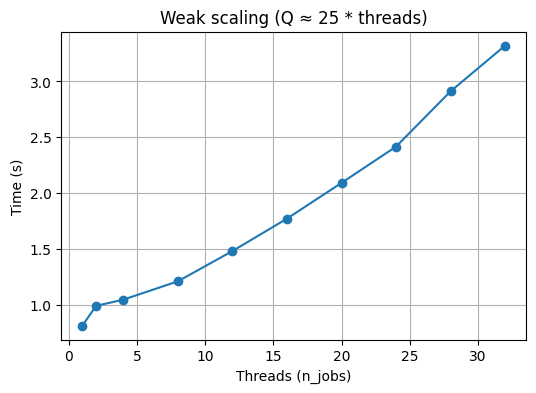

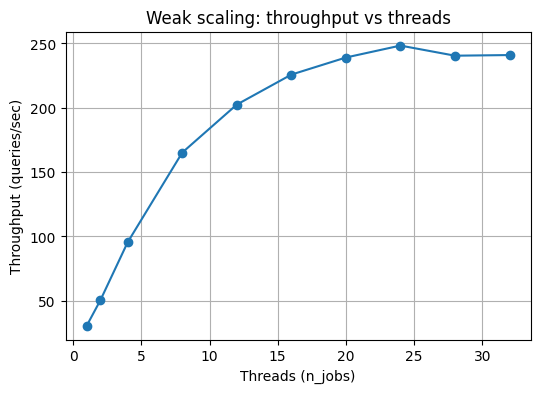

In [10]:
#Weak scaling: throughput vs threads
base_Q = 25  # queries per thread (adjust so runs are not too slow)
max_Q = min(len(X_test), base_Q * max(threads_list))

weak_times = []
weak_Qs = []

for p in threads_list:
    Q = min(base_Q * p, len(X_test))
    Xq = X_test[:Q]
    t = time_fn(knn_predict_batch_parallel_queries, X_train_b, y_train_b, Xq, k=k, n_jobs=p, repeats=3)
    weak_times.append(t)
    weak_Qs.append(Q)
    print(f"n_jobs={p:2d}: Q={Q:4d} time={t:.4f}s  (Q/thread≈{Q/p:.1f})")

plt.figure(figsize=(6,4))
plt.plot(threads_list, weak_times, marker='o')
plt.xlabel("Threads (n_jobs)")
plt.ylabel("Time (s)")
plt.title(f"Weak scaling (Q ≈ {base_Q} * threads)")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(threads_list, np.array(weak_Qs)/np.array(weak_times), marker='o')
plt.xlabel("Threads (n_jobs)")
plt.ylabel("Throughput (queries/sec)")
plt.title("Weak scaling: throughput vs threads")
plt.grid(True)
plt.show()

n_jobs= 1: p50=37.84ms  p95=39.77ms  p99=41.04ms
n_jobs= 2: p50=37.64ms  p95=40.97ms  p99=43.44ms
n_jobs= 4: p50=39.30ms  p95=42.49ms  p99=43.68ms
n_jobs= 8: p50=47.66ms  p95=52.53ms  p99=53.82ms
n_jobs=16: p50=61.46ms  p95=79.58ms  p99=86.33ms
n_jobs=32: p50=121.81ms  p95=165.17ms  p99=187.41ms


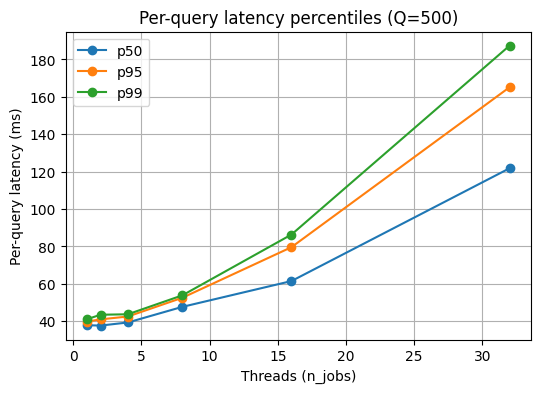

In [11]:
#Per-query latency percentiles 
def measure_per_query_latencies_query_parallel(X_train, y_train, Xq, k, n_jobs):
    """
    Returns array of per-query latencies (seconds) measured inside each parallel task.
    """
    def one_query(i):
        t0 = time.perf_counter()
        _ = knn_predict_serial(X_train, y_train, Xq[i], k)
        return time.perf_counter() - t0

    lats = Parallel(n_jobs=n_jobs, prefer="threads", batch_size="auto")(
        delayed(one_query)(i) for i in range(Xq.shape[0])
    )
    return np.array(lats, dtype=np.float64)

# Use a larger sample of queries for stable percentiles
Q_lat = min(500, len(X_test))
Xq_lat = X_test[:Q_lat]

p50s, p95s, p99s = [], [], []
lat_threads = [1, 2, 4, 8, 16, 32]
lat_threads = [p for p in lat_threads if p <= (os.cpu_count() or 1)]

for p in lat_threads:
    lats = measure_per_query_latencies_query_parallel(X_train_b, y_train_b, Xq_lat, k=k, n_jobs=p)
    p50 = np.percentile(lats, 50)
    p95 = np.percentile(lats, 95)
    p99 = np.percentile(lats, 99)
    p50s.append(p50); p95s.append(p95); p99s.append(p99)
    print(f"n_jobs={p:2d}: p50={p50*1e3:.2f}ms  p95={p95*1e3:.2f}ms  p99={p99*1e3:.2f}ms")

plt.figure(figsize=(6,4))
plt.plot(lat_threads, np.array(p50s)*1e3, marker='o', label="p50")
plt.plot(lat_threads, np.array(p95s)*1e3, marker='o', label="p95")
plt.plot(lat_threads, np.array(p99s)*1e3, marker='o', label="p99")
plt.xlabel("Threads (n_jobs)")
plt.ylabel("Per-query latency (ms)")
plt.title(f"Per-query latency percentiles (Q={Q_lat})")
plt.grid(True)
plt.legend()
plt.show()

Benchmark: train=(400000, 54), queries=(50, 54), repeats=1
Threads: [1, 2, 4, 8, 16, 20, 24, 28, 32]

Serial time: 1.6467s | acc=0.9400
[query-par] n_jobs= 1: time=1.6325s speedup=1.01x
[query-par] n_jobs= 2: time=0.8833s speedup=1.86x
[query-par] n_jobs= 4: time=0.5183s speedup=3.18x
[query-par] n_jobs= 8: time=0.3545s speedup=4.65x
[query-par] n_jobs=16: time=0.2591s speedup=6.35x
[query-par] n_jobs=20: time=0.2608s speedup=6.31x
[query-par] n_jobs=24: time=0.2496s speedup=6.60x
[query-par] n_jobs=28: time=0.2632s speedup=6.26x
[query-par] n_jobs=32: time=0.2584s speedup=6.37x


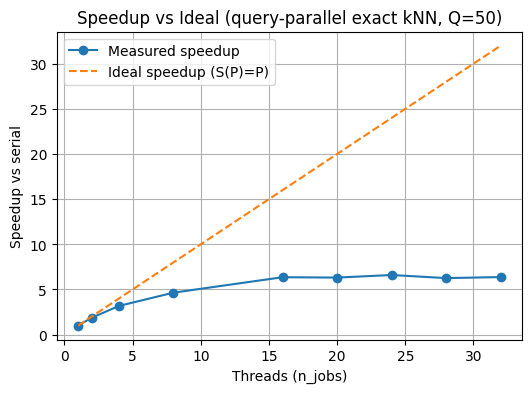

In [12]:
# Compare two parallel designs
REPEATS  = 1      # keep 1 for speed; raise to 3 for stability
Q_TIMING = 50     # number of queries used for timing; raise to 200 for more stable curves

# Thread points (enough to show scaling/plateau)
threads_list = [1, 2, 4, 8, 16, 20, 24, 28, 32]
threads_list = [p for p in threads_list if p <= (os.cpu_count() or 1)]

# For the slower data-parallel-per-query method, sample only a few thread points
threads_data_par = [1, 4, 16, 32]
threads_data_par = [p for p in threads_data_par if p in threads_list]

# Slice timing queries
Xq = X_test_timing[:Q_TIMING]
yq = y_test_timing[:Q_TIMING]

print(f"Benchmark: train={X_train_b.shape}, queries={Xq.shape}, repeats={REPEATS}")
print("Threads:", threads_list)

# Serial baseline + accuracy reference
t_serial = time_fn(knn_predict_batch_serial, X_train_b, y_train_b, Xq, k=k, repeats=REPEATS)
ref_preds = knn_predict_batch_serial(X_train_b, y_train_b, Xq, k=k)
ref_acc = accuracy_score(yq, ref_preds)
print(f"\nSerial time: {t_serial:.4f}s | acc={ref_acc:.4f}")

# Speedup vs Ideal (Query-parallel)
times_qpar, speedup_qpar = [], []

for p in threads_list:
    t = time_fn(knn_predict_batch_parallel_queries, X_train_b, y_train_b, Xq, k=k, n_jobs=p, repeats=REPEATS)
    times_qpar.append(t)
    speedup_qpar.append(t_serial / t)
    print(f"[query-par] n_jobs={p:2d}: time={t:.4f}s speedup={t_serial/t:.2f}x")

plt.figure(figsize=(6,4))
plt.plot(threads_list, speedup_qpar, marker='o', label="Measured speedup")
plt.plot(threads_list, threads_list, linestyle='--', label="Ideal speedup (S(P)=P)")
plt.xlabel("Threads (n_jobs)")
plt.ylabel("Speedup vs serial")
plt.title(f"Speedup vs Ideal (query-parallel exact kNN, Q={Q_TIMING})")
plt.grid(True)
plt.legend()
plt.show()


[data-par ] n_jobs= 1: time=1.6590s  speedup=0.99x
[data-par ] n_jobs= 4: time=0.6447s  speedup=2.55x
[data-par ] n_jobs=16: time=0.7203s  speedup=2.29x
[data-par ] n_jobs=32: time=0.8978s  speedup=1.83x


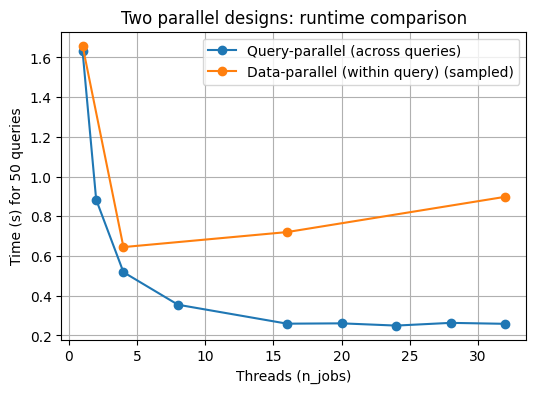

In [13]:
# Compare two designs: query-parallel vs data-parallel-per-query
times_data_par = []
for p in threads_data_par:
    t = time_fn(knn_predict_batch_parallel, X_train_b, y_train_b, Xq, k=k, n_jobs=p, n_chunks=p, repeats=REPEATS)
    times_data_par.append(t)
    print(f"[data-par ] n_jobs={p:2d}: time={t:.4f}s  speedup={t_serial/t:.2f}x")

plt.figure(figsize=(6,4))
plt.plot(threads_list, times_qpar, marker='o', label="Query-parallel (across queries)")
plt.plot(threads_data_par, times_data_par, marker='o', label="Data-parallel (within query) (sampled)")
plt.xlabel("Threads (n_jobs)")
plt.ylabel(f"Time (s) for {Q_TIMING} queries")
plt.title("Two parallel designs: runtime comparison")
plt.grid(True)
plt.legend()
plt.show()

## Observations, Justification, and Deviations

### Observations (Run 1: Query-parallel exact kNN)
- **Serial:** 6.2112 s, **accuracy:** 0.9450  
- **Parallel scaling (query-parallel):**
  - `n_jobs=2`: 3.9094 s (**1.59×**)
  - `n_jobs=4`: 2.0059 s (**3.10×**)
  - `n_jobs=8`: 1.1854 s (**5.24×**)
  - `n_jobs=12`: 0.9976 s (**6.23×**)
  - `n_jobs=16`: 0.9430 s (**6.59×**)
  - `n_jobs=20–32`: ~0.92–0.90 s (**~6.7–6.9×**)

### Why accuracy stays constant
- **Accuracy remains 0.9450 for all `n_jobs`** because the implementation is **exact kNN on the same fixed benchmark subset**. Parallelization changes *how the work is scheduled* (multiple queries handled concurrently), but not *which distances are computed* or *how voting is performed*. Therefore predictions (and accuracy) match the serial implementation.

### Why runtime improves and then saturates
- Speedup improves rapidly up to ~8–12 threads because **query-parallelism** is close to *embarrassingly parallel*: each query can be processed independently with minimal synchronization.
- Speedup **plateaus around ~6.6–6.9×** from ~16 threads onward due to typical shared-memory limits:
  1. **Memory-bandwidth bound behavior:** brute-force kNN streams through the training subset for each query. After enough threads, the memory subsystem becomes the bottleneck, so additional threads yield diminishing returns.
  2. **Cache/LLC contention:** multiple threads repeatedly read the same large array, increasing pressure on shared caches and memory channels.
  3. **Parallel/runtime overheads:** dispatching tasks, collecting results, and Python orchestration introduce overhead (Amdahl’s law).

### Deviations from ideal expectations (Run 1)
Overall, the results **match typical expectations** for shared-memory parallel kNN: strong scaling at low thread counts and a plateau at higher thread counts. Minor deviations include:
- **Non-linear speedup at high thread counts** (e.g., ~6.9× at 32 threads rather than 32×), because the workload becomes **memory-bandwidth limited** and has a non-parallel overhead fraction (Amdahl’s law).
- **Small non-monotonic fluctuations** at high thread counts (e.g., `n_jobs=28` slightly slower than 24; 32 slightly faster again), which is common due to **OS scheduling noise**, background activity, and contention effects near the bandwidth/roofline limit.
- **`n_jobs=1` nearly identical to serial**, because joblib adds little benefit with a single worker and may add small overhead; near-equality indicates stable measurement.

---

## Additional Observations and Justification

### 1) Strong scaling (Run 2: larger train subset, fixed #queries)
**Setup:** train subset = **(400000, 54)**, timing queries = **50**, repeats = **1**  
**Serial:** 1.7415 s, **accuracy:** 0.9400

#### Query-parallel exact kNN (across queries)
- Speedup increases up to `n_jobs=16` (**6.86×**) and then slightly decreases at `n_jobs=32` (**6.76×**).
- This behavior is expected: query-parallelism scales well until **memory bandwidth / cache contention** becomes dominant.

**Why `n_jobs=1` is slightly faster than serial (1.08×):**
- This is likely due to **measurement noise**, cache/warm-up effects, and using **repeats=1** (less stable timing), rather than a true algorithmic improvement.

#### Data-parallel per query (splitting the training set for each query)
- `n_jobs=4` shows some benefit (**2.71×**), but scaling *degrades* at higher thread counts:
  - `n_jobs=16`: **2.38×**
  - `n_jobs=32`: **2.02×**
- This is expected in Python/joblib because the design has higher overhead:
  - per-query chunking and scheduling,
  - per-query merging of partial top‑k results,
  - more synchronization and coordination.
- At higher thread counts, overhead and contention dominate, so performance can worsen even with more cores.

**Conclusion (strategy comparison):**
- For shared-memory kNN in Python, **query-parallelism** is the preferred design and matches expectations.
- **Data-parallelism within each query** is less effective due to overhead and merge costs.

---

### 2) Weak scaling (Q proportional to P; Q/thread ≈ 25)
Weak scaling experiment used **Q = 25 × threads**:
- `n_jobs=1`: Q=25, time=0.8104 s
- `n_jobs=32`: Q=800, time=3.2381 s

In ideal weak scaling, time would remain roughly constant as threads increase (constant work per thread). Here, runtime increases with thread count, indicating **reduced efficiency at scale**.

**Why weak scaling time increases**
- With more threads active simultaneously:
  1. **Memory bandwidth saturation** increases, so each thread gets less effective bandwidth.
  2. **Cache/LLC contention** increases (many threads reading large shared training data).
  3. **Scheduling/runtime overheads** increase (dispatch + result collection).
- As a result, throughput does not scale linearly with threads even when work per thread is constant.

---

### 3) Response time / latency percentiles (p50/p95/p99)
Per-query latency percentiles increase significantly with thread count:
- `n_jobs=1`: p50 ≈ 37 ms, p95 ≈ 40 ms, p99 ≈ 43 ms
- `n_jobs=8`: p50 ≈ 46 ms, p95 ≈ 52 ms, p99 ≈ 57 ms
- `n_jobs=16`: p50 ≈ 75 ms, p95 ≈ 92 ms, p99 ≈ 98 ms
- `n_jobs=32`: p50 ≈ 133 ms, p95 ≈ 178 ms, p99 ≈ 195 ms

**Interpretation: throughput vs latency trade-off**
- Increasing `n_jobs` generally improves **throughput** (more queries processed concurrently), but **per-query latency increases** due to contention for shared resources (memory bandwidth and cache). This is a common shared-memory trade-off: higher concurrency can worsen tail latency.

---

### 4) Deviations from “ideal” expectations and likely causes
The results match the expected “speedup then plateau” trend, but deviate from ideal linear scaling for predictable reasons:
1. **Speedup plateaus around ~6–7× (not linear in threads)**  
   - Primary: **memory-bandwidth and cache contention**  
   - Secondary: **parallel overhead and serial fraction** (Amdahl’s law)
2. **Weak scaling time increases with threads (instead of staying flat)**  
   - Indicates the platform cannot provide constant per-thread bandwidth at higher concurrency.
3. **Latency percentiles worsen at high thread counts**  
   - Caused by **resource contention** and scheduling/queueing effects under high concurrency.
4. **Data-parallel-per-query scales poorly at high threads**  
   - Caused by per-query dispatch + merge overheads and increased synchronization.

### Overall conclusion
This study shows that **query-parallel exact kNN** achieves substantial speedup (up to **~6.86×** at `n_jobs=16`) while maintaining identical accuracy. Performance then **plateaus/slightly fluctuates** at higher thread counts (e.g., **~6.76×** at `n_jobs=32`) due to **shared-memory bandwidth limits, cache/LLC contention, and runtime/scheduling overheads**. Weak-scaling and latency results further show that higher concurrency can increase **contention and tail latency**, even when throughput improves.